In [200]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [201]:
words = open('names.txt').read().splitlines()

In [202]:
len(words)

32658

In [203]:
# build vocab of characters and mappings to / from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'ó', 28: 'ę', 29: 'ł', 30: 'ń', 31: 'ś', 32: 'ż', 0: '.'}
33


In [204]:
import random
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))  
n2 = int(0.9 * len(words))
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

## structuring code so it look more like pytorch

In [392]:
g = torch.Generator().manual_seed(42)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5) 
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        params = [{'param': self.weight, 'type': 'weight'}]
        if self.bias is not None:
            params.append({'param': self.bias, 'type': 'bias'})
        return params

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [{'param': self.gamma, 'type': 'weight'}, {'param': self.beta, 'type': 'bias'}]
    
class LeakyRelu:
    def __call__(self, x):
        self.out = torch.nn.functional.leaky_relu(x)
        return self.out
    
    def parameters(self):
        return []
    

class Adam:
    def __init__(self, params, lr=0.00001, beta1 = 0.9, beta2 = 0.999, eps = 1e-08):
        self.lr = lr
        self.params = params
        self.beta1 = torch.tensor(beta1)
        self.beta2 = torch.tensor(beta2)
        self.eps = eps
        self.m_d = {id(p['param']): torch.zeros_like(p['param']) for p in params}
        self.v_d = {id(p['param']): torch.zeros_like(p['param']) for p in params}
        self.t = 1

    def step(self):
        for p in self.params:
            param = p['param']
            grad = param.grad
            param_type = p['type']

            m = self.m_d[id(param)]
            v = self.v_d[id(param)]

            next_m = (torch.multiply(self.beta1, m) + torch.multiply(1.0 - self.beta1, grad))
            next_v = (torch.multiply(self.beta2, v) + torch.multiply(1.0 - self.beta2, torch.pow(grad, 2)))

            m_hat = torch.divide(next_m, (1 - torch.pow(self.beta1, self.t)))
            v_hat = torch.divide(next_v, (1 - torch.pow(self.beta2, self.t)))

            param.data = param.data - torch.divide(torch.multiply(self.lr, m_hat), (torch.sqrt(v_hat) + self.eps))

            self.m_d[id(param)] = next_m
            self.v_d[id(param)] = next_v
        self.t += 1

In [393]:
n_embd = 10
n_hidden = 100
block_size = 3
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden), LeakyRelu(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight /= 10
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= np.sqrt(2 / (1 + (0.01)**2))

C = {'param': C, 'type': 'weight'}
parameters = [C] + [p for layer in layers for p in layer.parameters()]
parameters
print(sum(p['param'].numel() for p in parameters))
for p in parameters:
    p['param'].requires_grad_()

47163


In [394]:
max_steps = 20000
batch_size = 128
lossi = []
# optimizer = torch.optim.Adam([p['param'] for p in parameters], lr=0.001)  
optimizer = Adam([p for p in parameters], lr=0.001)

for i in range(max_steps):
    ix = torch.randint(0, Xtrain.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    C_params = C['param']
    emb = C_params[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p['param'].grad = None
    loss.backward()

    # adam optimizer:
    optimizer.step()

    # stochastic gradient descent:
    # lr = 0.1 if i < 100000 else 0.01
    # for p in parameters:
    #     p.data -= lr * p.grad

    if i % 1000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    # print(loss.item())
    # if i > 1000:
    #     break

      0/  20000: 3.4992
   1000/  20000: 2.2849
   2000/  20000: 2.3190
   3000/  20000: 2.2606
   4000/  20000: 1.9244
   5000/  20000: 1.9359
   6000/  20000: 2.1450
   7000/  20000: 2.0486
   8000/  20000: 2.2115
   9000/  20000: 2.1126
  10000/  20000: 2.2207
  11000/  20000: 2.1167
  12000/  20000: 2.2713
  13000/  20000: 1.8618
  14000/  20000: 2.0388
  15000/  20000: 2.2227
  16000/  20000: 2.0977
  17000/  20000: 1.9314
  18000/  20000: 1.9692
  19000/  20000: 1.7972


layer 1 ( LeakyRelu): mean +0.41, std 0.72, saturated: 28.51%
layer 3 ( LeakyRelu): mean +0.39, std 0.77, saturated: 24.18%
layer 5 ( LeakyRelu): mean +0.39, std 0.83, saturated: 23.80%
layer 7 ( LeakyRelu): mean +0.45, std 0.92, saturated: 24.16%
layer 9 ( LeakyRelu): mean +0.40, std 0.95, saturated: 22.26%


Text(0.5, 1.0, 'activation distribution')

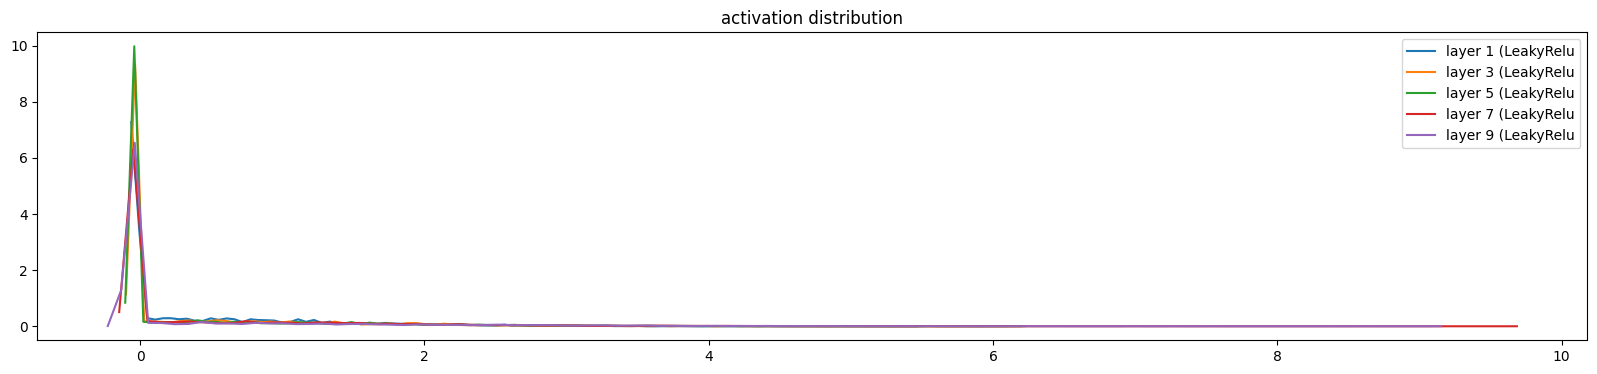

In [398]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, LeakyRelu):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() < 0.01).float().mean() * 100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 1 ( LeakyRelu): mean +0.000014, std 1.375752e-03
layer 3 ( LeakyRelu): mean -0.000002, std 1.087187e-03
layer 5 ( LeakyRelu): mean -0.000002, std 8.609249e-04
layer 7 ( LeakyRelu): mean -0.000001, std 7.462988e-04
layer 9 ( LeakyRelu): mean -0.000001, std 9.324660e-04


Text(0.5, 1.0, 'gradient distribution')

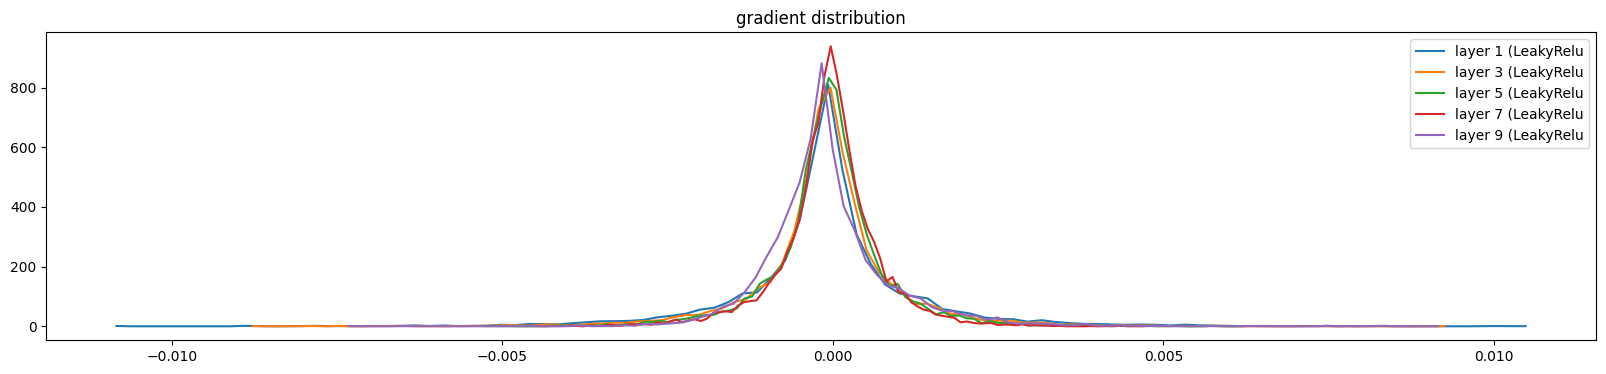

In [399]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, LeakyRelu):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (33, 10) | mean -0.000654 | std 8.886033e-03 | grad:data ratio 8.711378e-03
weight  (30, 100) | mean -0.000089 | std 8.497340e-03 | grad:data ratio 2.886735e-02
weight (100, 100) | mean -0.000447 | std 5.638607e-03 | grad:data ratio 2.735145e-02
weight (100, 100) | mean +0.000196 | std 4.496288e-03 | grad:data ratio 2.148407e-02
weight (100, 100) | mean -0.000035 | std 3.956222e-03 | grad:data ratio 1.890419e-02
weight (100, 100) | mean -0.000008 | std 3.404553e-03 | grad:data ratio 1.640239e-02
weight  (100, 33) | mean +0.000000 | std 1.211325e-02 | grad:data ratio 4.409426e-02


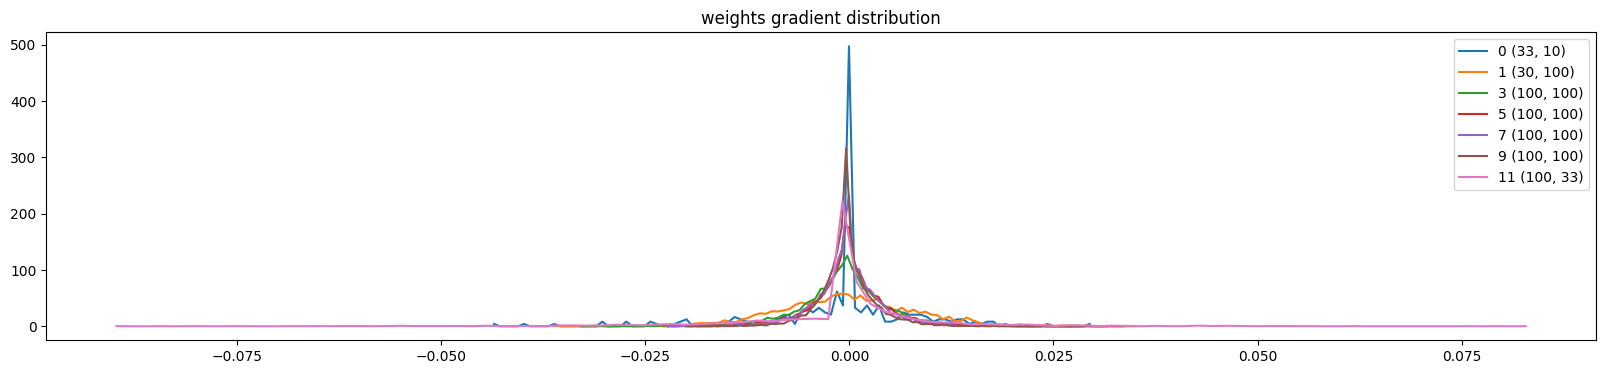

In [402]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p['param'].grad
  if p['param'].ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p['param'].shape), t.mean(), t.std(), t.std() / p['param'].std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"{i} {tuple(p['param'].shape)}")
plt.legend(legends)
plt.title('weights gradient distribution');